In [36]:
  #!/usr/bin/env python

try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as nc
from gi.repository import NumCosmoMath as ncm
import numpy as np
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.insert(0,'/home/henrique/Programas_Cosmologia/CLCosmo_Sim/cluster_abundance/')
sys.path.insert(0,'../scripts')

import pyccl as ccl
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count
import CL_COUNT_modeling_richness as richness_model

from nc_ccl import create_nc_obj, ccl_cosmo_set_high_prec

ncm.cfg_init()
ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


initialize the `Cosmological models`

In [37]:
#CCL cosmology
cosmo_ccl = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8822714165197718, n_s=0.96, Omega_k = 0, transfer_function='eisenstein_hu')
ccl_cosmo_set_high_prec (cosmo_ccl)

cosmo_numcosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj (cosmo_ccl)

psf = hmfunc.peek_psf ()

# Define proxy modelling
Use a mass proxy, define the probability for observing a proxy given a mass and redhsift

$$
P(\log\lambda|M,z) = N(\mu(M,z), \sigma^2(M,z))
$$
the mean is
$$
\mu(M,z) = \mu_0 + a_\mu^M\log_{10}\frac{M}{M_0} + a_\mu^z\log_{10}\frac{1+z}{1+z_0} 
$$
variance is
$$
\sigma(M,z) = \sigma_0 + a_\sigma^M\log_{10}\frac{M}{M_0} + a_\sigma ^z\log_{10}\frac{1+z}{1+z_0} 
$$

In [38]:
#CosmoSim_proxy model
#M_0, z_0
theta_pivot = [3e14/0.71, 0.6]
#\mu_0, a_\mu^z, a_\mu^M
theta_mu = [3.19, -0.7, 2]
#\sigma_0, a_\sigma^z, a_\sigma^M
theta_sigma = [0.33, 0.,-0.08]
#Richness object
richness = richness_model.Richness(theta_mu, theta_sigma, theta_pivot)

#Numcosmo_proxy model
cluster_z = nc.ClusterRedshift.new_from_name("NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (0,2))
cluster_m = nc.ClusterMass.new_from_name("NcClusterMassAscaso{'M0':<%20.15e>,'Z0':<%20.15e>,'lnRichness-min':<%20.15e>, 'lnRichness-max':<%20.15e>}" % (3e14/(0.71),0.6, 0, np.log(10) * np.log10(10e6)))
cluster_m.param_set_by_name('mup0', 3.19)
cluster_m.param_set_by_name('mup1', 2/np.log(10))
cluster_m.param_set_by_name('mup2', -0.7/np.log(10))
cluster_m.param_set_by_name('sigmap0', 0.33)
cluster_m.param_set_by_name('sigmap1', -0.08/np.log(10))
cluster_m.param_set_by_name('sigmap2', 0/np.log(10))

1.9984014443252818e-15

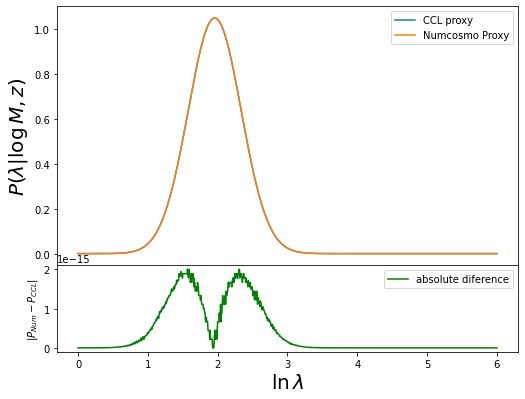

In [39]:
proxy_array = np.linspace(0,6,1000)
z = 0.5
logM = np.log(10)*np.log10(1e14)
pdf_clusterm = []
for lnrichness in proxy_array:
    pdf_clusterm.append(cluster_m.p(cosmo_numcosmo, logM, z, [lnrichness],None))

diff = abs((pdf_clusterm - richness.pdf(proxy_array,z,logm = 14)))

fig1 = plt.figure(figsize=(8,6))
frame1=fig1.add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([])
plt.plot(proxy_array,richness.pdf(proxy_array,z,logm = 14), label = 'CCL proxy')
plt.plot(proxy_array,pdf_clusterm, label= 'Numcosmo Proxy')
plt.legend()
plt.ylabel(r'$P(\lambda|\log M, z)$', fontsize = 20)

frame2=fig1.add_axes((.1,.1,.8,.2))        
plt.plot(proxy_array,diff, c='g', label = 'absolute diference')
plt.legend()
plt.xlabel('$\ln \lambda$', fontsize = 20)
plt.ylabel(r'$|P_{Num} - P_{CCL}|$', fontsize = 10)
diff.max()

initialize the `ClusterAbundance` object

In [40]:
#CCL cluster abundance
clc = cl_count.ClusterAbundance()
#choose mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo_ccl, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi


#Numcosmo Cluster Abundance

#First we need to define the multiplicity function here we will use the tinker
mulf = nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp (True)
mulf.set_mdef(nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)
#Second we need to construct a filtered power spectrum 

hmf = nc.HaloMassFunction.new(dist,psf,mulf)
hmf.set_area((0.25)*4*np.pi)


ca = nc.ClusterAbundance.new(hmf,None)
mset = ncm.MSet.new_array([cosmo_numcosmo,cluster_m,cluster_z])
mset.pretty_log()

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.7                [FIXED]
#   -     Omegac[01]:  0.258856            [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.725               [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.048254            [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

# Un-binned approach

$$
x_i = \int_{\log_{10}M_{min}}^{\log_{10}M_{min}}\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M,z_i)}{d\log_{10}M}P(\lambda_i|M,z_i)d\log_{10}M
$$

In [41]:
#Generates the cluster catalog
import random
z_array = np.linspace(0.1,2,100)
random.shuffle(z_array)
proxy_array = np.linspace(1,4,100)

In [42]:
#Using CCL
z_grid = np.linspace(0., 3, 1000)
logm_grid = np.linspace(13,15, 1000)
clc.compute_pdf_grid_ProxyZ(proxy = proxy_array, z = z_array, proxy_model = richness, z_grid = z_grid, logm_grid = logm_grid)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
dndproxy_exact_CCL = clc.multiplicity_function_individual_ProxyZ(z = z_array, proxy = proxy_array, proxy_model = richness, method = 'exact')
dndproxy_exact_CCL *= clc.sky_area

In [43]:
#Using Numcosmo
ca.prepare(cosmo_numcosmo,cluster_z,cluster_m)
dndproxy_numcosmo = []
for richness_i in range(len(proxy_array)):
    dndproxy_numcosmo.append(ca.lnM_p_d2n(cosmo_numcosmo,cluster_z,cluster_m,[proxy_array[richness_i]],None,z_array[richness_i]))

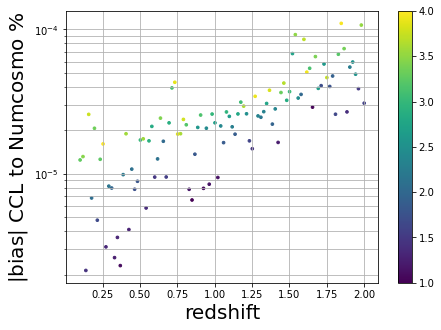

In [44]:
plt.figure(figsize = (7,5))
plt.scatter(z_array, 100*abs(np.array(dndproxy_numcosmo)-np.array(dndproxy_exact_CCL))/np.array(dndproxy_numcosmo), s = 7, c = proxy_array, cmap = 'viridis')
plt.colorbar()
plt.xlabel('redshift', fontsize = 20)
plt.ylabel('|bias| CCL to Numcosmo $\%$', fontsize = 20)
plt.yscale('log')
plt.grid(True, which="both")

# Binned approach

Comptue the integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\lambda_{\beta}}^{\lambda_{\beta + 1}}d\lambda\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}P(\lambda|M,z)d\log_{10}M
$$

In [49]:
#Bins definition
z_edges = np.linspace(0.25, 1, 5)
proxy_edges = np.linspace(0, 2, 4)

In [50]:
#Using CCL
N_ProxyZ_exact = clc.Cluster_Abundance_ProxyZ(zbin_edges = z_edges, proxybin_edges = proxy_edges, logm_limit = [min(logm_grid), max(logm_grid)],proxy_model = richness, method = 'exact')

In [52]:
#Using Numcosmo
ca.prepare(cosmo_numcosmo,cluster_z,cluster_m)
N_proxy_numcosmo = []


for rich_l, rich_u in zip(proxy_edges, proxy_edges[1:]):
    N_zbin = []
    for zl, zu in zip(z_edges,z_edges[1:]):
        N_zbin.append(ca.intp_bin_d2n(cosmo_numcosmo,cluster_z,cluster_m, [rich_l], [rich_u],None ,[zl],[zu], None))
    
    N_proxy_numcosmo.append(N_zbin)

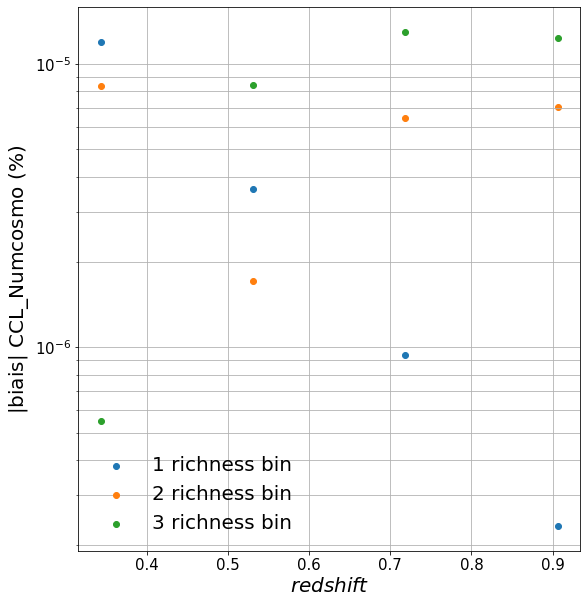

In [63]:
plt.figure(figsize = (9,10))
plt.yscale('log')
z_ = [np.mean([z_edges[i],z_edges[i+1]]) for i in np.arange(len(z_edges)-1)]
proxy = [np.mean([proxy_edges[i],proxy_edges[i+1]]) for i in np.arange(len(proxy_edges)-1)]


plt.tick_params(axis='both', which="both", labelsize= 15)
for f in range(len(proxy_edges)-1):
    if f == 0:
        label = []
    y_simps = abs(100*(1-N_ProxyZ_exact[:,f]/N_proxy_numcosmo[:][f]))
    plt.scatter(z_, y_simps, label = str(f+1)+' richness bin')
plt.grid(True, which="both" )
plt.ylabel(r'|biais| CCL_Numcosmo $(\%)$', fontsize = 20)
plt.xlabel(r'$redshift$', fontsize = 20)
plt.legend(frameon = False, fontsize = 20)